In [1]:
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

### Step 1: Download the data.

In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


### Step 2: Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000


def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5241, 3084, 12, 6, 195, 2, 3136, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Step 3: Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):#8/2=4
    target = skip_window  # target label at the center of the buffer #1->quick
    targets_to_avoid = [skip_window]#quick
    for j in range(num_skips):#2
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)# randomly take other than quick
      targets_to_avoid.append(target)# quick, the
      batch[i * num_skips + j] = buffer[skip_window]#
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])#
    data_index = (data_index + 1) % len(data)
  return batch, labels
# sw is no of terms in win, ns is times to consider that win
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3084 originated -> 12 as
3084 originated -> 5241 anarchism
12 as -> 6 a
12 as -> 3084 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


### Step 4: Build and train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    
# Number of negative examples to sample.
graph = tf.Graph()

with graph.as_default():
  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))
  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)
  # Add variable initializer.
  init = tf.global_variables_initializer()

print ('train_inputs', train_inputs.get_shape())
print ('train_labels', train_labels.get_shape())
print ('valid_dataset', valid_dataset.get_shape())
print ('embeddings', embeddings.get_shape())
print ('embed', embed.get_shape())
print ('norm', norm.get_shape())
print ('normalized_embeddings', normalized_embeddings.get_shape())
print ('similarity', similarity.get_shape())

train_inputs (128,)
train_labels (128, 1)
valid_dataset (16,)
embeddings (50000, 128)
embed (128, 128)
norm (50000, 1)
normalized_embeddings (50000, 128)
similarity (16, 50000)


### Step 5: Begin training.

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  294.168762207
Nearest to world: loosened, defection, nail, inevitably, dvds, siberian, eyelids, compliant,
Nearest to nine: forrest, heartland, subversive, wave, imitates, candles, vegetation, concerned,
Nearest to d: glenda, carols, utilise, juridical, publicity, daoxuan, attitude, reparation,
Nearest to united: whitney, fullerenes, mafia, finalised, urim, hatched, gas, sorrow,
Nearest to as: stereotypically, swahili, counterfactual, microbe, domesticated, conclusive, wordsworth, gunmen,
Nearest to which: emigration, fireballs, equinox, comedian, mercator, cherbourg, kursk, nervousness,
Nearest to such: gamers, danny, mildred, ashcroft, minotaurs, porridge, mosquitia, reactivity,
Nearest to of: arden, anxiolytics, finnegans, trophies, subseteq, premise, acquainted, leads,
Nearest to between: cv, parachutes, amplify, ulm, reawakened, blows, holiest, doraemon,
Nearest to six: cooper, siddur, mash, skipped, sony, crime, tempore, binding,
Nearest to 

### Step 6: Visualize the embeddings.

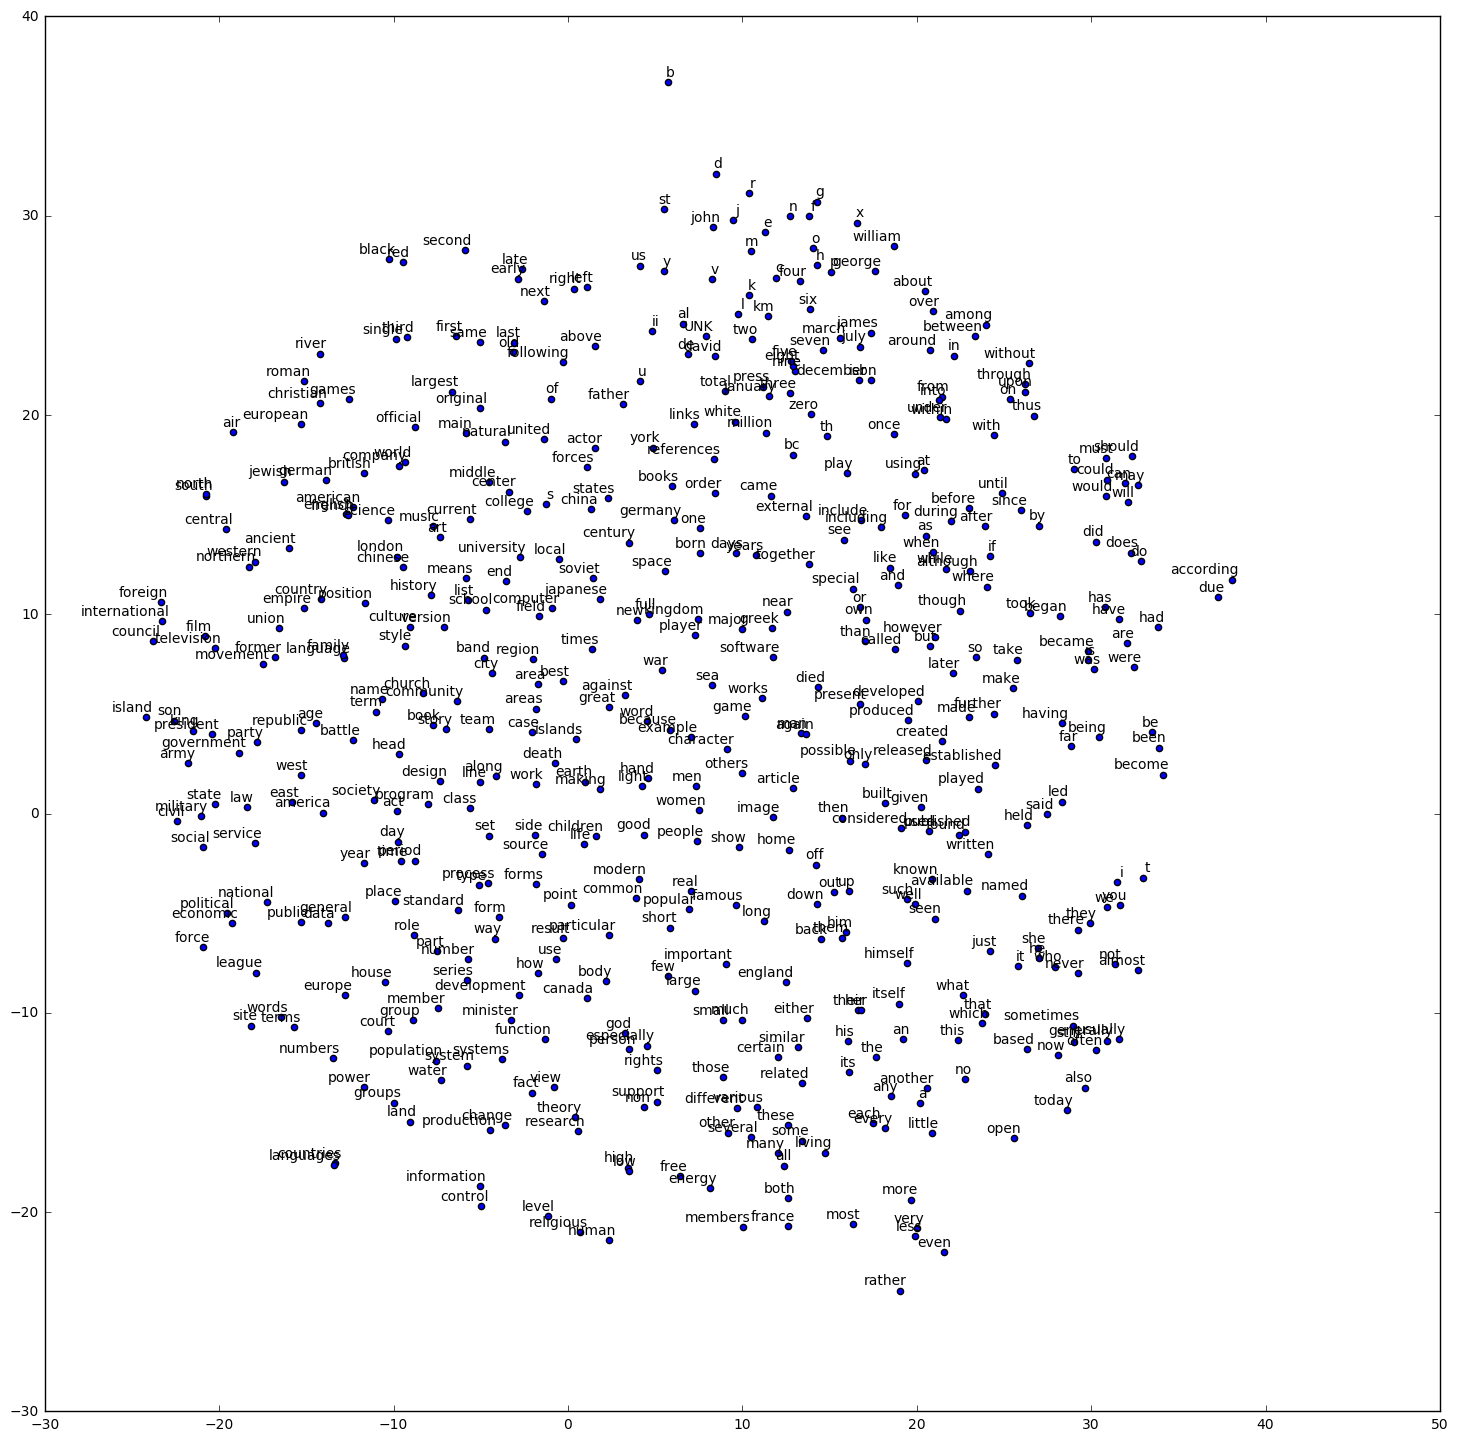

In [8]:
%matplotlib inline

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")


### CBOW
An alternative to Word2Vec is called CBOW (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

The main difference between skip-gram and CBOW is the inputs and outputs are reversed - skip-gram predicts the context given the word, while CBOW predicts the word given the context. The second difference is that unlike skip-gram where each context word is a separate, label, in CBOW the context words are summed together in the input vector (so instead of having a single bit "activated" we'll have 2 or more bits turned on). This blog post explains it pretty well, although the exact implementation used here isn't as complicated as the one suggested in the post.

The code is very similar to skip-gram, with the exception of the batch generation function.

In [12]:
data_index = 0

def generate_batch_cbow(batch_size, skip_window):
  global data_index
  context_window = 2 * skip_window
  assert batch_size % context_window == 0
  num_labels = batch_size // context_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(num_labels):
    target = skip_window  # target label at the center of the buffer
    labels[i, 0] = buffer[target]
    targets_to_avoid = [ skip_window ]
    for j in range(context_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * context_window + j] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [13]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
context_window = 2 * skip_window
num_labels = batch_size / context_window
# num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 32 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[num_labels, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)

  # Create a mask to apply to the embed tensor to essentially "sum" the context words
  seq_ids = np.zeros(batch_size, dtype=np.int32)
  cur_id = -1
  for i in range(batch_size):
    if i % context_window == 0:
      cur_id = cur_id + 1
    seq_ids[i] = cur_id
  
  # Use segment_sum to add together the related words and reduce the output to be num_labels in size.
  embed_sum = tf.segment_sum(embed, seq_ids)
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed_sum,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.554763
Nearest to on: anarchistic, eugenic, ranked, specified, rida, horthy, heresiologists, rhymes,
Nearest to for: out, ortelius, famines, tera, wahhabism, hypothesize, clan, usurpers,
Nearest to states: guang, aquila, pmid, frick, jacquard, metastability, bakongo, toys,
Nearest to only: award, committed, ecumenism, textbook, deadweight, objects, pomeroy, performance,
Nearest to while: jeannie, spiny, maroons, abercrombie, echolocation, chaldeans, heresy, covalently,
Nearest to history: button, versatility, scanning, restrain, interpolation, taliban, intestines, grind,
Nearest to there: cogito, keeps, movies, printable, socialism, paws, kokomo, dq,
Nearest to their: vending, chains, bowled, credited, file, thumbs, chickasaw, battles,
Nearest to six: omnibus, samsara, chaim, rectified, residual, npd, unshielded, superclass,
Nearest to at: firefox, remarque, islas, motor, dra

In [15]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [16]:
%matplotlib inline

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

NameError: name 'pylab' is not defined